<a href="https://colab.research.google.com/github/BruceTsai0909/Machine-Learning-Projects/blob/master/Predicting_Stock_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf

from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

company = 'TSM'
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)

data = yf.download(company, start=start, end=end)

data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,13.110000,13.350000,13.060000,13.260000,9.436189,8910500
2012-01-04,13.150000,13.210000,13.040000,13.140000,9.350795,7386600
2012-01-05,13.190000,13.280000,13.140000,13.260000,9.436189,10306100
2012-01-06,13.270000,13.270000,13.090000,13.150000,9.357913,7775800
2012-01-09,13.150000,13.390000,13.130000,13.380000,9.521587,7543100
...,...,...,...,...,...,...
2019-12-24,57.990002,58.090000,57.549999,57.759998,53.704716,2692200
2019-12-26,57.799999,58.349998,57.759998,58.250000,54.160313,2490400
2019-12-27,58.529999,58.709999,58.330002,58.459999,54.355564,2847800


Epoch 1/25
61/61 [==============================] - 7s 60ms/step - loss: 0.0149
Epoch 2/25
61/61 [==============================] - 3s 53ms/step - loss: 0.0026
Epoch 3/25
61/61 [==============================] - 3s 53ms/step - loss: 0.0027
Epoch 4/25
61/61 [==============================] - 4s 61ms/step - loss: 0.0025
Epoch 5/25
61/61 [==============================] - 3s 53ms/step - loss: 0.0020
Epoch 6/25
61/61 [==============================] - 3s 53ms/step - loss: 0.0021
Epoch 7/25
61/61 [==============================] - 3s 54ms/step - loss: 0.0019
Epoch 8/25
61/61 [==============================] - 4s 60ms/step - loss: 0.0017
Epoch 9/25
61/61 [==============================] - 4s 59ms/step - loss: 0.0019
Epoch 10/25
61/61 [==============================] - 4s 64ms/step - loss: 0.0017
Epoch 11/25
61/61 [==============================] - 4s 68ms/step - loss: 0.0017
Epoch 12/25
61/61 [==============================] - 3s 55ms/step - loss: 0.0017
Epoch 13/25
61/61 [==================

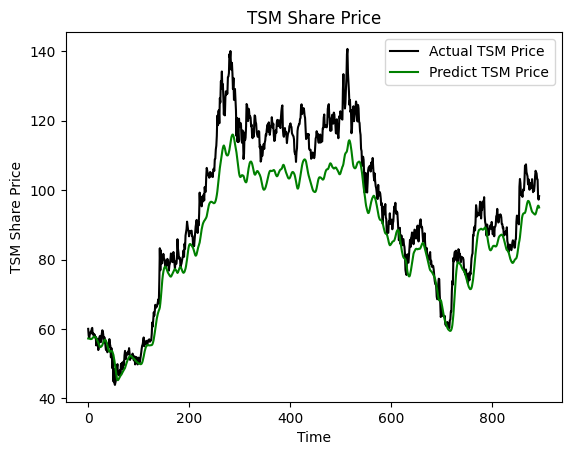

In [11]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #prediction of the next close value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

'''test the model accuracy on existing data'''

test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

test_data = yf.download(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

#make predictions on testdata

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

#plot the test prediction

plt.plot(actual_prices, color = 'black', label = f'Actual {company} Price')
plt.plot(predicted_prices, color = 'green', label = f'Predict {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

